In [352]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib.pyplot import ``1q1
pd.set_option("display.max_rows", 100)
from sklearn.preprocessing import MinMaxScaler

<h3> Importing Stock Price Data

<p> downloading the ticker symbols of S&P500 stocks from wikipedia

In [353]:
tickers_list_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', 
                                attrs={'class':'wikitable sortable'},
                                header=0)[0]['Symbol']

<p> Need to clean up the symbol names so that it can be downloaded downstream

In [354]:
tickers_list = list(map(lambda st: str.replace(st, ".", "-"), tickers_list_raw))

In [ ]:
tickers_df = pd.DataFrame(tickers_list, columns =['Symbol']) 
tickers_df.to_csv('s&p500_tickers_list.csv', index=False)

<p> Downloading the stock market daily trading data for 10 years

In [ ]:
# data = yf.download(tickers_list, period="10y", auto_adjust=False)
# tickers_list= ["AAPL"]
tickers_list_tmp = tickers_list
data_raw = yf.download(tickers_list_tmp, start="2010-01-01", end="2020-11-30")

<p> Flatten the hierarchy index and write to a csv file for future usage

In [ ]:
data_raw.columns = ['_'.join(col).strip() for col in data_raw.columns.values]
data_raw.to_csv('trading_daily_s&p500.csv')
data_raw.head()

<H3> Data Exploration

In [356]:
data = pd.read_csv('trading_daily_s&p500.csv').set_index('Date')#.dropna(axis=1)
data.shape

(2753, 3036)

In [19]:
data.filter(regex='AAPL$|MSFT$', axis=1)[:6]

,Adj Close_AAPL,Adj Close_MSFT,Close_AAPL,Close_MSFT,High_AAPL,High_MSFT,Low_AAPL,Low_MSFT,Open_AAPL,Open_MSFT,Volume_AAPL,Volume_MSFT
Date,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,6.593426,24.105360,7.643214,30.950001,7.660714,31.100000,7.585000,30.590000,7.622500,30.620001,493729600.0,38409100.0
2010-01-05,6.604825,24.113148,7.656428,30.959999,7.699643,31.100000,7.616071,30.639999,7.664286,30.850000,601904800.0,49749600.0
2010-01-06,6.499768,23.965164,7.534643,30.770000,7.686786,31.080000,7.526786,30.520000,7.656428,30.879999,552160000.0,58182400.0
2010-01-07,6.487752,23.715933,7.520714,30.450001,7.571429,30.700001,7.466072,30.190001,7.562500,30.629999,477131200.0,50559700.0
2010-01-08,6.530883,23.879499,7.570714,30.660000,7.571429,30.879999,7.466429,30.240000,7.510714,30.280001,447610800.0,51197400.0


<P> Cleaning the raw data to remove rows with Nan and null values

In [357]:
data = data[~data.isnull().all(1)]
data.shape

(2746, 3036)

<p> Cleaning the raw data to remove columns having Nan and null values

In [365]:
data.drop(data.columns[data.isnull().any()], axis=1, inplace=True)
data.shape

(2746, 2694)

<p> Visulaize time series data of the target stock

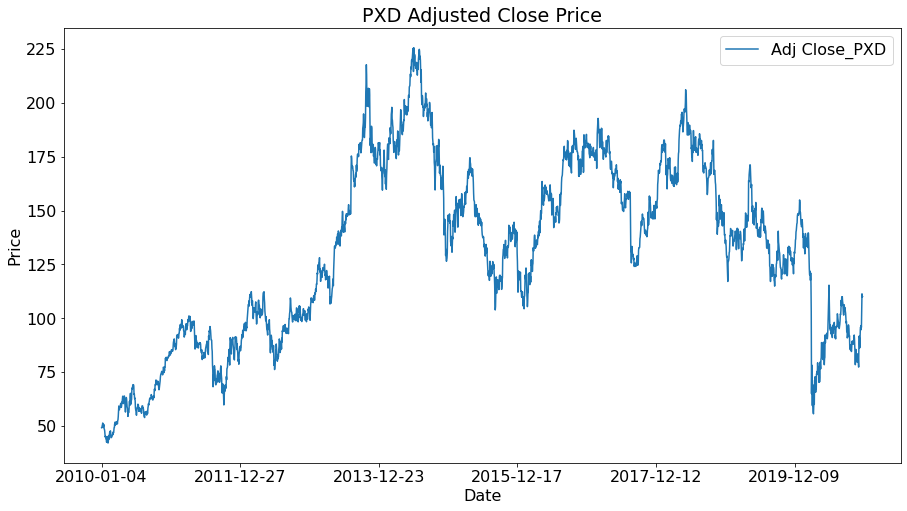

In [362]:
plt.figure(figsize=(15,8))
stock = "PXD"
adj_close = "Adj Close_" + stock
plt.rcParams.update({'font.size': 16})
fig = data[adj_close].plot(title= stock + ' Adjusted Close Price')
fig.set_ylabel('Price')
fig.legend(loc='upper right')
plt.show(fig)

<h3> Data Preprocesing

<p> Find the Pearson correlation coefficent of target varible with all other variables 

In [366]:
r1 = data.corr(min_periods=10).abs()[adj_close]
r1 = r1.sort_values(ascending = False)
r1

Adj Close_PXD    1.000000
Close_PXD        0.999879
High_PXD         0.999063
Low_PXD          0.999027
Open_PXD         0.997979
                   ...   
Volume_FAST      0.002803
Volume_CMG       0.001431
Volume_WLTW      0.000778
Volume_ARE       0.000714
Adj Close_FE     0.000509
Name: Adj Close_PXD, Length: 2694, dtype: float64

<p>Select only th features greater than the selected threshold and shift the data by 1 day ahead such that prior day's data is the feature for predicting today's adj close price

In [367]:
threshold_ratio = 0.8
features = data[r1[r1 > threshold_ratio].index].shift(1).dropna()
features

,Adj Close_PXD,Close_PXD,High_PXD,Low_PXD,Open_PXD,Close_EOG,Low_EOG,High_EOG,Open_EOG,Adj Close_EOG,...,Low_JCI,Close_JCI,Close_WAB,Close_WFC,Open_JCI,Open_WFC,Open_WAB,High_JCI,High_WFC,High_WAB
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,49.169010,50.980000,51.150002,49.380001,49.380001,50.189999,49.619999,50.220001,49.674999,45.348362,...,18.665976,18.879389,20.860001,27.320000,18.728437,27.020000,20.674999,19.025137,27.480000,20.969999
2010-01-06,49.188301,51.000000,51.779999,50.790001,51.060001,49.575001,48.895000,50.000000,49.505001,44.792683,...,18.671181,18.785696,20.865000,28.070000,18.848158,27.270000,20.770000,18.947058,28.240000,20.930000
2010-01-07,50.046680,51.889999,52.369999,50.560001,51.000000,49.740002,48.834999,49.845001,49.419998,44.941780,...,18.692001,18.723232,20.995001,28.110001,18.775286,28.030001,20.850000,18.848158,28.330000,21.270000
2010-01-08,50.490337,52.349998,52.689999,50.290001,51.389999,49.275002,48.720001,49.525002,49.445000,44.521626,...,18.629538,18.858568,21.014999,29.129999,18.749258,28.120001,21.004999,18.900211,29.430000,21.120001
2010-01-11,51.358376,53.250000,53.349998,51.380001,51.599998,49.525002,48.145000,49.645000,48.865002,44.747509,...,18.655565,18.921032,21.355000,28.860001,18.785696,28.900000,20.959999,18.983494,29.350000,21.475000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,96.629997,96.629997,96.800003,93.000000,93.900002,45.459999,44.110001,45.610001,44.450001,45.459999,...,45.119999,45.709999,72.349998,26.160000,45.790001,25.190001,71.970001,45.900002,26.219999,72.559998
2020-11-23,95.809998,95.809998,97.250000,94.870003,96.239998,45.389999,44.570000,46.020000,45.099998,45.389999,...,45.029999,45.290001,70.980003,25.480000,45.520000,26.040001,72.040001,45.759998,26.230000,72.279999
2020-11-24,104.500000,104.500000,104.529999,97.300003,97.500000,50.380001,46.049999,50.459999,46.130001,50.380001,...,45.459999,45.650002,73.550003,26.299999,45.590000,25.950001,71.360001,46.060001,26.440001,73.559998


Text(0.5, 1.0, 'Histogram of Pearson Correlation coefficient for PXD')

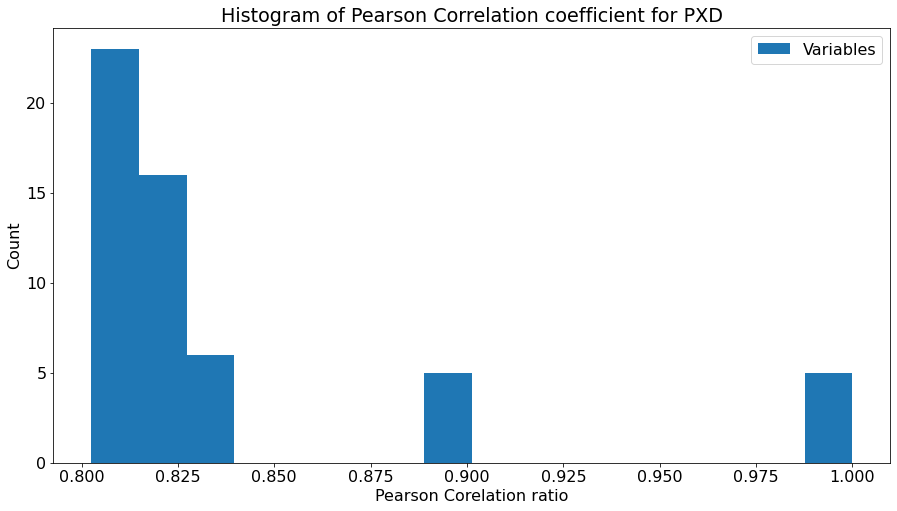

In [368]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
plt.hist(r1[r1 > threshold_ratio], bins='auto', label="Variables")
plt.ylabel('Count')
plt.xlabel('Pearson Corelation ratio')
plt.legend(loc="upper right")
plt.title("Histogram of Pearson Correlation coefficient for " + stock)

<p> Create target variable

In [369]:
target = data[adj_close][1:]
target.shape

(2745,)

<p> Drop target variable from the features 

In [370]:
features.drop([adj_close], axis=1, inplace=True)

<p> Min-Max scale on the features

In [371]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features = pd.DataFrame(min_max_scaler.fit_transform(features), 
                             columns=features.columns, 
                             index=features.index)
features.head()

,Close_PXD,High_PXD,Low_PXD,Open_PXD,Close_EOG,Low_EOG,High_EOG,Open_EOG,Adj Close_EOG,Low_IP,...,Low_JCI,Close_JCI,Close_WAB,Close_WFC,Open_JCI,Open_WFC,Open_WAB,High_JCI,High_WFC,High_WAB
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.038849,0.036704,0.039695,0.030851,0.199142,0.219399,0.194138,0.206965,0.167603,0.165702,...,0.034320,0.038671,0.025139,0.137977,0.028557,0.133140,0.023276,0.034246,0.135767,0.025037
2010-01-06,0.038955,0.040013,0.047158,0.039711,0.193147,0.212367,0.192010,0.205327,0.161916,0.165057,...,0.034490,0.035670,0.025191,0.154722,0.032421,0.138715,0.024261,0.031728,0.152682,0.024624
2010-01-07,0.043653,0.043111,0.045941,0.039395,0.194756,0.211785,0.190511,0.204508,0.163442,0.178382,...,0.035170,0.033670,0.026545,0.155615,0.030069,0.155665,0.025091,0.028539,0.154685,0.028135
2010-01-08,0.046081,0.044791,0.044511,0.041451,0.190223,0.210669,0.187415,0.204749,0.159142,0.157750,...,0.033131,0.038004,0.026753,0.178388,0.029229,0.157672,0.026698,0.030217,0.179168,0.026586
2010-01-11,0.050831,0.048257,0.050281,0.042559,0.192660,0.205092,0.188576,0.199162,0.161454,0.148294,...,0.033980,0.040004,0.030292,0.172360,0.030405,0.175067,0.026231,0.032903,0.177387,0.030251


<p> Train-Test split

In [372]:
features_train = features[features.index<='2018-12-31']
features_test = features[features.index>'2018-12-31']
print('Training features shape: {}'.format(features_train.shape))
print('Testing features shape: {}'.format(features_test.shape))

Training features shape: (2263, 54)
Testing features shape: (482, 54)


In [373]:
features_test.head()

,Close_PXD,High_PXD,Low_PXD,Open_PXD,Close_EOG,Low_EOG,High_EOG,Open_EOG,Adj Close_EOG,Low_IP,...,Low_JCI,Close_JCI,Close_WAB,Close_WFC,Open_JCI,Open_WFC,Open_WAB,High_JCI,High_WFC,High_WAB
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.463975,0.467916,0.465968,0.461133,0.559996,0.575849,0.568292,0.578172,0.559350,0.439055,...,0.376524,0.383570,0.539270,0.556821,0.381020,0.555977,0.521928,0.385295,0.558647,0.533839
2019-01-03,0.478649,0.486085,0.459405,0.449583,0.593138,0.564500,0.591120,0.553608,0.592716,0.445811,...,0.376850,0.410789,0.545620,0.576021,0.369725,0.545941,0.524728,0.404645,0.569108,0.548810
2019-01-04,0.480918,0.480834,0.478565,0.482228,0.586899,0.594180,0.590733,0.601194,0.586436,0.455400,...,0.402636,0.395098,0.531255,0.567761,0.402642,0.570919,0.536755,0.411741,0.578010,0.537866
2019-01-07,0.504988,0.502678,0.495501,0.497574,0.625402,0.621532,0.620526,0.611791,0.625199,0.480244,...,0.417977,0.433525,0.549680,0.598571,0.405869,0.588091,0.541420,0.433349,0.594925,0.566878
2019-01-08,0.520982,0.523577,0.511591,0.506276,0.631153,0.632590,0.640936,0.638667,0.630989,0.500511,...,0.443437,0.449857,0.542601,0.591650,0.435237,0.596120,0.549611,0.453990,0.597596,0.554489


In [374]:
target_train = target[target.index<='2018-12-31']
target_test = target[target.index>'2018-12-31']
print('Training target shape: {}'.format(target_train.shape))
print('Testing targer shape: {}'.format(target_test.shape))

Training target shape: (2263,)
Testing targer shape: (482,)


<p> Spliting the data into multiple timesteps

In [375]:
sequence_length = 5
def split_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(split_sequence(features_train,sequence_length)))
print('Training input array shape: {}'.format(seq_array.shape)) 
seq_array_test = np.array(list(split_sequence(features_test,sequence_length)))
print('Testing input array shape: {}'.format(seq_array_test.shape)) 

Training input array shape: (2258, 5, 54)
Testing input array shape: (477, 5, 54)


In [376]:
def split_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(split_labels(target_train,sequence_length)))
print('Training Target Array shape: {}'.format(label_array.shape)) 
label_array_test = np.array(list(split_labels(target_test,sequence_length)))
print('Testing target array shape: {}'.format(label_array_test.shape)) 

Training Target Array shape: (2258,)
Testing target array shape: (477,)


<h3> Benchmark model

<H4>  Linear regression model

In [377]:
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression()

<p> Model performance

In [378]:
prediction_lr = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))

In [379]:
filename = stock.replace(" ", "_") + '_linear_regression_model.csv'
prediction_graph = pd.DataFrame([prediction_lr,label_array_test]).T.rename({0:'predicted_value',1:'actual_value'},axis=1).set_index(target.index[target.index>='2019-01-09'])
prediction_graph.to_csv(filename)
prediction_graph.shape

(477, 2)

<Figure size 1080x576 with 0 Axes>

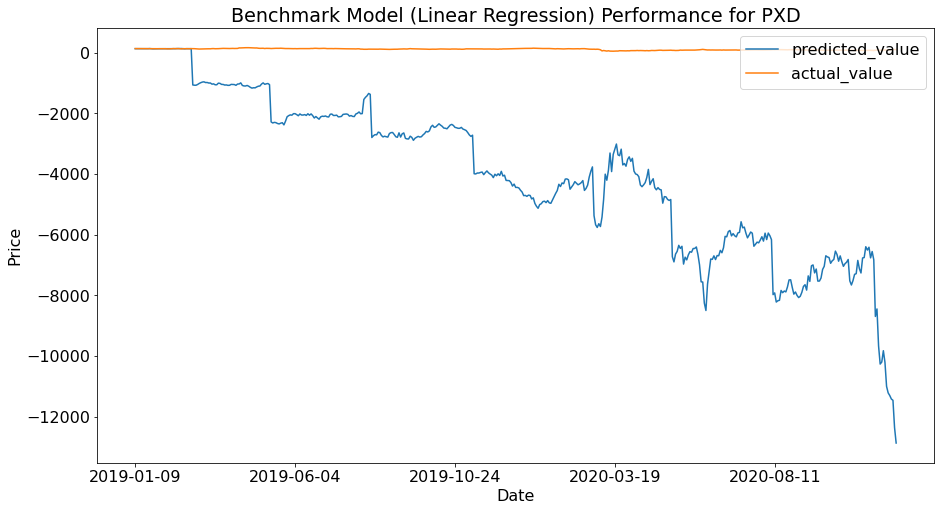

In [380]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
prediction_graph.plot(figsize=(15,8))
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc="upper right")
plt.title("Benchmark Model (Linear Regression) Performance for " + stock)
plt.show()

In [381]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction_lr),np.sqrt(mean_squared_error(label_array_test,prediction_lr))

(-35723.288173891095, 4848.643123249506)

<h4> Vanilla LSTM

In [384]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import tensorflow as tf

# build the network
nb_features = seq_array.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, nb_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 50)                21000     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total params: 21,051
Trainable params: 21,051
Non-trainable params: 0
_________________________________________________________________


In [385]:
history_vanilla_LSTM = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

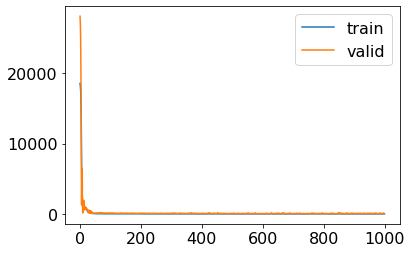

In [386]:
plt.plot(history_vanilla_LSTM.history['loss'], label='train')
plt.plot(history_vanilla_LSTM.history['val_loss'], label='valid')
plt.legend()
plt.show()

<p> Model performance

In [387]:
prediction_vanilla_LSTM = model.predict(seq_array_test)
prediction_vanilla_LSTM.shape

(477, 1)

In [388]:
filename = stock.replace(" ", "_") + '_vanilla_LSTM.csv'
prediction_graph_vanilla_LSTM= pd.DataFrame([np.squeeze(prediction_vanilla_LSTM),label_array_test]).T.rename({0:'predicted_value',1:'actual_value'},axis=1).set_index(target.index[target.index>='2019-01-09'])
prediction_graph_vanilla_LSTM.to_csv(filename)
prediction_graph_vanilla_LSTM.shape

(477, 2)

<Figure size 1080x576 with 0 Axes>

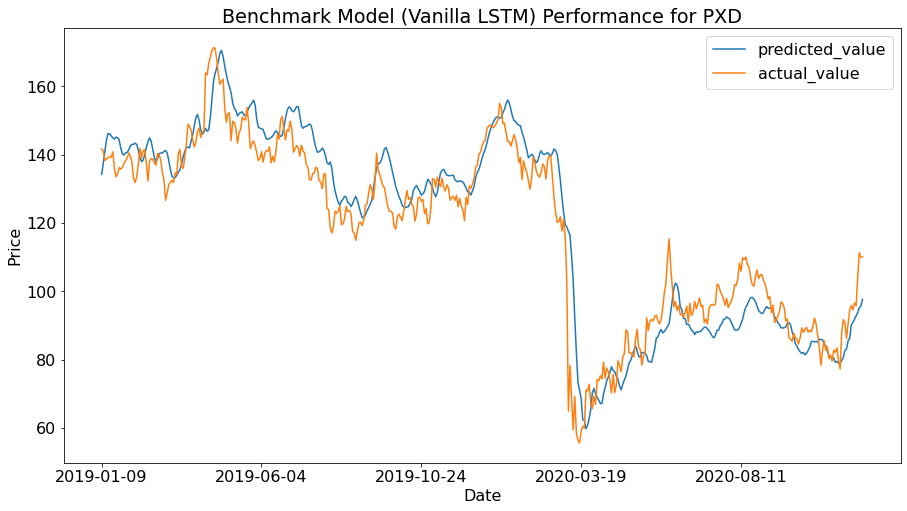

In [389]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
prediction_graph_vanilla_LSTM.plot(title='Benchmark Model Performance',figsize=(15,8))
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc="upper right")
plt.title("Benchmark Model (Vanilla LSTM) Performance for " + stock)
plt.show()

In [390]:
r2_score(label_array_test,prediction_vanilla_LSTM),np.sqrt(mean_squared_error(label_array_test,prediction_vanilla_LSTM))

(0.8817606575711594, 8.821032671505115)

<h3> Bidirectional LSTM model

In [391]:
# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(Bidirectional(LSTM(150, activation='relu',return_sequences=True ), input_shape=(sequence_length, nb_features)))

model.add(LSTM(
          units=85,
          return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=75,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 5, 300)            246000    
_________________________________________________________________
lstm_54 (LSTM)               (None, 5, 85)             131240    
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 85)             0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 75)                48300     
_________________________________________________________________
dropout_33 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 76        
Total params: 425,616
Trainable params: 425,616
Non-trainable params: 0
_______________________________________________

In [392]:
history_bi_LSTM = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

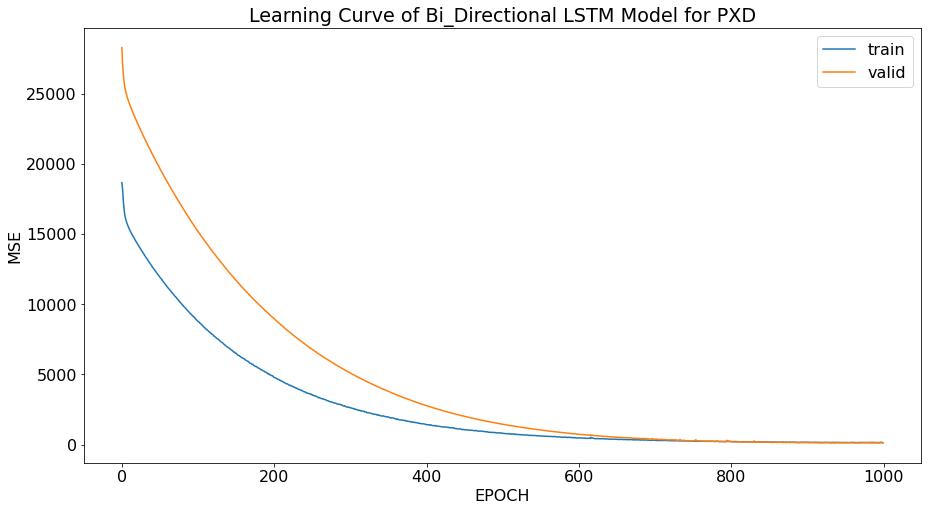

In [393]:
plt.figure(figsize=(15,8))
plt.plot(history_bi_LSTM.history['loss'], label='train')
plt.plot(history_bi_LSTM.history['val_loss'], label='valid')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('EPOCH')
plt.title("Learning Curve of Bi_Directional LSTM Model for "+ stock)
plt.show()

<p>model performance

In [394]:
prediction_bi_LSTM = model.predict(seq_array_test)

In [395]:
filename = stock.replace(" ", "_") + '_bi_LSTM.csv'
prediction_graph_bi_LSTM= pd.DataFrame([np.squeeze(prediction_bi_LSTM),label_array_test]).T.rename({0:'predicted_value',1:'actual_value'},axis=1).set_index(target.index[target.index>='2019-01-09'])
prediction_graph_bi_LSTM.to_csv(filename)
prediction_graph_bi_LSTM.shape

(477, 2)

<Figure size 1080x576 with 0 Axes>

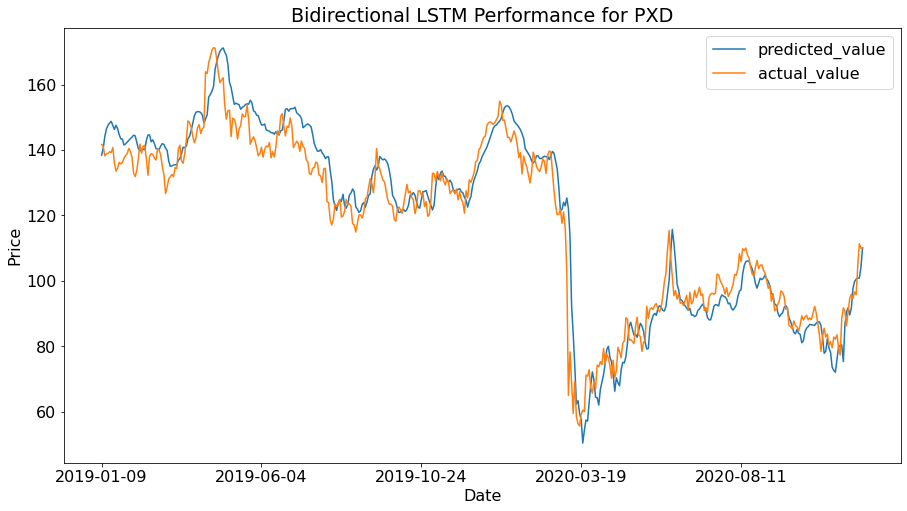

In [396]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
prediction_graph_bi_LSTM.plot(title='Benchmark Model Performance',figsize=(15,8))
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc="upper right")
plt.title("Bidirectional LSTM Performance for "+ stock)
plt.show()

In [397]:
r2_score(label_array_test,prediction_bi_LSTM),np.sqrt(mean_squared_error(label_array_test,prediction_bi_LSTM))

(0.9173952025847536, 7.372946167190457)

<h3> LSTM STACKED 2

In [398]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 5, 100)            62000     
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 92,251
Trainable params: 92,251
Non-trainable params: 0
_________________________________________________________________


In [399]:
history_stacked2_LSTM = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

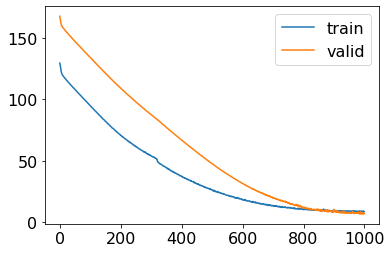

In [401]:
plt.plot(history_stacked2_LSTM.history['loss'], label='train')
plt.plot(history_stacked2_LSTM.history['val_loss'], label='valid')
plt.legend()
plt.show()

<p> model performance

In [402]:
prediction_sttacked2_LSTM = model.predict(seq_array_test)
filename = stock.replace(" ", "_") + '_stacked2_LSTM.csv'
prediction_graph_sttacked2_LSTM= pd.DataFrame([np.squeeze(prediction_sttacked2_LSTM),label_array_test]).T.rename({0:'predicted_value',1:'actual_value'},axis=1).set_index(target.index[target.index>='2019-01-09'])
prediction_graph_sttacked2_LSTM.to_csv(filename)
prediction_graph_sttacked2_LSTM.shape

(477, 2)

<Figure size 1080x576 with 0 Axes>

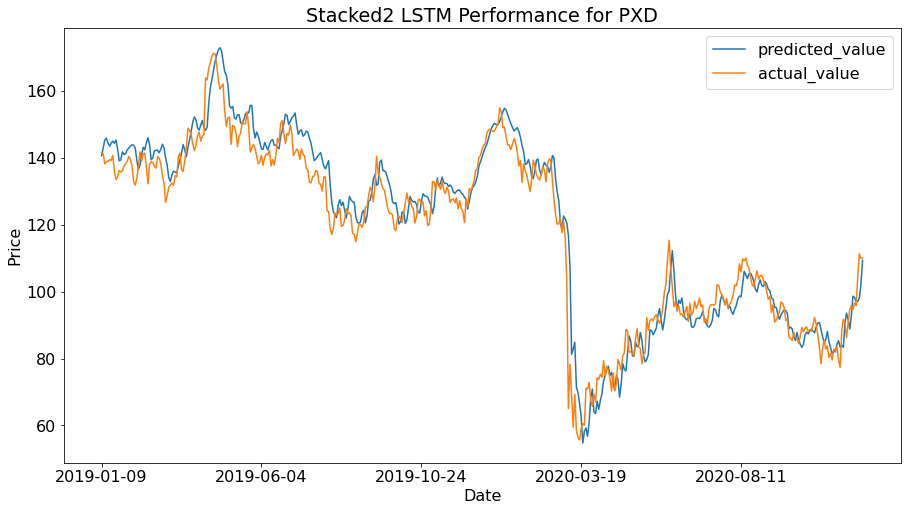

In [403]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
prediction_graph_sttacked2_LSTM.plot(title='Benchmark Model Performance',figsize=(15,8))
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc="upper right")
plt.title("Stacked2 LSTM Performance for " + stock)
plt.show()

In [404]:
r2_score(label_array_test,prediction_sttacked2_LSTM),np.sqrt(mean_squared_error(label_array_test,prediction_sttacked2_LSTM))

(0.9346429221203122, 6.558201271288721)

<h3>LSTM STACKED 1

In [405]:
# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(sequence_length, nb_features), return_sequences=True))

model.add(LSTM(
          units=85,
          return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=75,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 5, 150)            123000    
_________________________________________________________________
lstm_59 (LSTM)               (None, 5, 85)             80240     
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 85)             0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 75)                48300     
_________________________________________________________________
dropout_37 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 76        
Total params: 251,616
Trainable params: 251,616
Non-trainable params: 0
_______________________________________________

In [406]:
history_stacked_LSTM = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

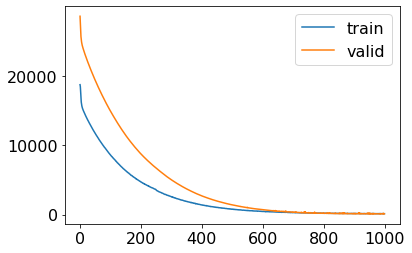

In [407]:
plt.plot(history_stacked_LSTM.history['loss'], label='train')
plt.plot(history_stacked_LSTM.history['val_loss'], label='valid')
plt.legend()
plt.show()

<p> model performance

In [408]:
prediction_stacked_LSTM = model.predict(seq_array_test)

In [409]:
filename = stock.replace(" ", "_") + '_stacked_LSTM.csv'
prediction_graph_stacked_LSTM= pd.DataFrame([np.squeeze(prediction_bi_LSTM),label_array_test]).T.rename({0:'predicted_value',1:'actual_value'},axis=1).set_index(target.index[target.index>='2019-01-09'])
prediction_graph_stacked_LSTM.to_csv(filename)
prediction_graph_stacked_LSTM.shape

(477, 2)

<Figure size 1080x576 with 0 Axes>

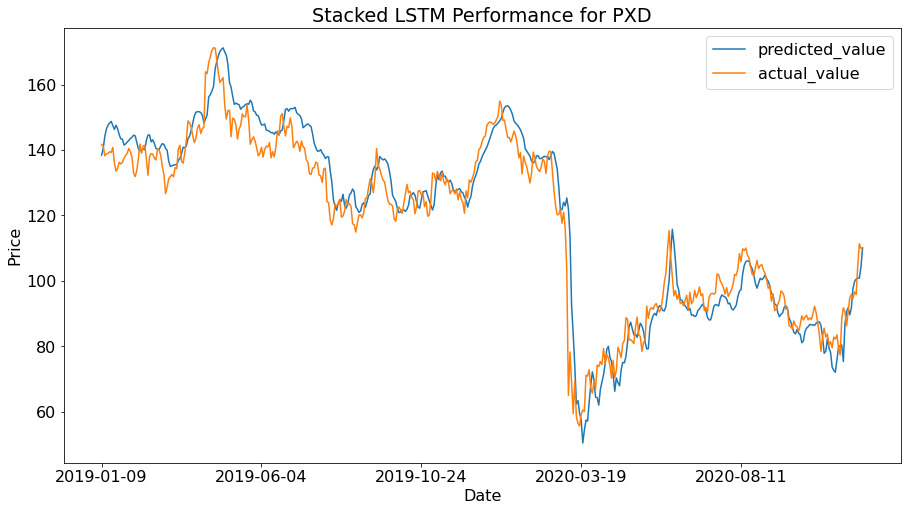

In [410]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
prediction_graph_stacked_LSTM.plot(title='Benchmark Model Performance',figsize=(15,8))
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc="upper right")
plt.title("Stacked LSTM Performance for "+ stock)
plt.show()

In [411]:
r2_score(label_array_test,prediction_stacked_LSTM),np.sqrt(mean_squared_error(label_array_test,prediction_stacked_LSTM))

(0.8535570698990906, 9.816860795240927)